In [1]:
from tqdm import tqdm
import os
from copy import deepcopy
import pickle
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from datasets.ascad_datasets import AscadDataset, RandomShift, RandomNoise
from models.resnet_1d import resnet18
from models.cnn import EffNetDS50
from training.single_model import train_step, eval_step
from training.common import execute_epoch
from display_results import plot_traces

In [2]:
model = EffNetDS50((1, 700), (256,), width_multiplier=10)
print(model)

EffNetDS50(
  (feature_extractor): Sequential(
    (0): Dropout(p=0.0, inplace=False)
    (1): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
    (2): SELU()
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (5): Conv1d(32, 64, kernel_size=(25,), stride=(1,), padding=(12,))
    (6): SELU()
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): AvgPool1d(kernel_size=(25,), stride=(25,), padding=(0,))
    (9): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (10): SELU()
    (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  )
  (fc): Sequential(
    (0): Dropout(p=0.0, inplace=False)
    (1): Linear(in_features=384, out_features=150, bias=True)
    (2): SELU()
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_feature

In [3]:
epochs_per_trial = 500
device = 'cuda'
results_path = os.path.join('.', 'results', 'disc_hparam_sweep')

#hparams_to_sweep = {
#    'dataset_kwargs': [
#        {'transform': RandomShift(), 'traces_per_sample': val} for val in range(1, 3)
#    ]
#}

hparams_to_sweep = {
    'dataset_kwargs': [
        {'transform': Compose((RandomShift(), RandomNoise(max_convex_coef=x)))} for x in np.logspace(-5, 0, 5)
    ] + [
        {'transform': RandomShift(), 'mixup': True}
    ],
    'input_dropout': [1e-3, 1e-2, 5e-2, 1e-1, 5e-1],
    'dropout': [1e-3, 1e-2, 5e-2, 1e-1, 5e-1],
    'batch_size': [64, 128, 256, 512, 1024]
}

#hparams_to_sweep = {
#    'dataset_kwargs': [
#        #{'transform': RandomShift(max_shift_size=0), 'mixup': False},
#        {'transform': RandomShift(), 'mixup': False},
#        {'transform': Compose((RandomShift(max_shift_size=0), RandomNoise())), 'mixup': False},
#        {'transform': RandomShift(max_shift_size=0), 'mixup': True},
#        {'transform': Compose((RandomShift(), RandomNoise())), 'mixup': False},
#        {'transform': RandomShift(), 'mixup': True},
#        {'transform': Compose((RandomShift(max_shift_size=0), RandomNoise())), 'mixup': True},
#        {'transform': Compose((RandomShift(), RandomNoise())), 'mixup': True}
#    ]
#}

#hparams_to_sweep = {
#    'learning_rate': [1e-3, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2],
#    'weight_decay': [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
#    'dropout': [0, 1e-3, 1e-2, 1e-1, 5e-1],
#    'batch_size': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]}

In [4]:
#class LossFn:
#    def __init__(self):
#        self.bce_loss = nn.BCELoss()
#    def __call__(self, logits, target):
#        prediction = nn.functional.softmax(logits, dim=-1)
#        if target.shape != prediction.shape:
#            target = nn.functional.one_hot(target, num_classes=256).to(torch.float)
#        loss = self.bce_loss(prediction, target)
#        return loss

LossFn = nn.CrossEntropyLoss
from torch.optim.lr_scheduler import OneCycleLR as LRScheduler

Starting new dataset_kwargs trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [4:02:35<00:00, 28.89s/it]

Done. Min rank: 124.93300000000004
	New best min rank. Previous best: inf


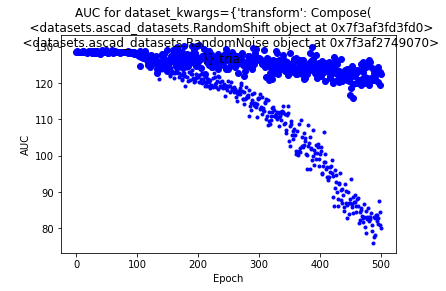

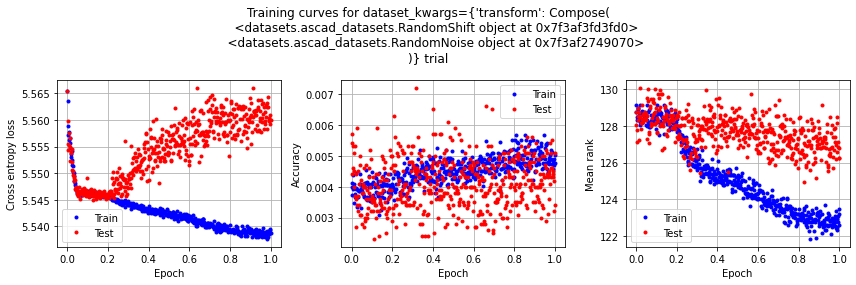







Starting new dataset_kwargs trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [4:02:37<00:00, 29.06s/it]

  1%|█▋                                                                                                                                                                     | 5/501 [02:18<3:54:41, 28.39s/it]ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/min/a/jgammell/anaconda3/envs/sca_defense/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_30214/2542940718.py", line 87, in <module>
    train_epoch(epoch)
  File "/tmp/ipykernel_30214/2542940718.py", line 63, in train_epoch
    results = execute_epoch(train_step, train_dataloader,
  File "/local/scratch/a/jgammell/sca_defense/training/common.py", line 31, in execute_epoch
    for batch in dataloader:
  File "/home/min/a/jgammell/anaconda3/envs/sca_defense/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 517, in __next__
    data = self._next_data()
  File "/home/min/a/jgammell/anaconda3/envs/sca_defense/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 557, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/home/min/a/jgammell/anaconda3/envs/sca_d

TypeError: object of type 'NoneType' has no len()

In [4]:
default_lr = 1e-5
default_width_multiplier = 32
default_weight_decay = 0
default_dropout = 0.
default_input_dropout = 0.
default_batch_size = 100
default_dataset_kwargs = {'transform': RandomShift()}

for hparam_name, values_to_try in hparams_to_sweep.items():
    best_min_rank = np.inf
    for value in values_to_try:
        min_rank = np.inf
        if hparam_name == 'learning_rate':
            learning_rate = value
        else:
            learning_rate = default_lr
        if hparam_name == 'weight_decay':
            weight_decay = value
        else:
            weight_decay = default_weight_decay
        if hparam_name == 'dropout':
            dropout = value
        else:
            dropout = default_dropout
        if hparam_name == 'input_dropout':
            input_dropout = value
        else:
            input_dropout = default_input_dropout
        if hparam_name == 'batch_size':
            batch_size = value
        else:
            batch_size = default_batch_size
        if hparam_name == 'dataset_kwargs':
            dataset_kwargs = value
        else:
            dataset_kwargs = default_dataset_kwargs
        if hparam_name == 'width_multiplier':
            width_multiplier = value
        else:
            width_multiplier = default_width_multiplier
        print('Starting new {} trial...'.format(hparam_name))
        print('\tLearning rate: {}'.format(learning_rate))
        print('\tWeight decay: {}'.format(weight_decay))
        print('\tDropout: {}'.format(dropout))
        print('\t')
        print('\tBatch size: {}'.format(batch_size))
        if 'traces_per_sample' in dataset_kwargs:
            traces_per_sample = dataset_kwargs['traces_per_sample']
        else:
            traces_per_sample = 1
        train_dataset = AscadDataset(train=True, **dataset_kwargs)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_dataset = AscadDataset(train=False, transform=RandomShift(max_shift_size=0), traces_per_sample=traces_per_sample)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
        model = EffNetDS50((traces_per_sample, 700), (256,), width_multiplier=traces_per_sample, dropout=dropout, input_dropout=input_dropout).to(device) #resnet18(dropout=dropout).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        lr_scheduler = LRScheduler(optimizer, 1e-3, pct_start=0.2, cycle_momentum=False, epochs=epochs_per_trial, steps_per_epoch=len(train_dataloader))
        loss_fn = LossFn()
        
        train_auc, test_auc = [], []
        def train_epoch(idx, train=True):
            if train:
                results = execute_epoch(train_step, train_dataloader,
                                        model, loss_fn, optimizer, device, callback=lr_scheduler.step)
            else:
                results = execute_epoch(eval_step, train_dataloader,
                                        model, loss_fn, device)
            train_auc.append(results['auc'])
            with open(os.path.join(results_path, 'hparam_{}_val_{}__train_epoch_{}.pickle'.format(hparam_name, value, idx)), 'wb') as F:
                pickle.dump(results, F)
        def eval_epoch(idx):
            global min_rank
            results = execute_epoch(eval_step, test_dataloader,
                                    model, loss_fn, device)
            test_auc.append(results['auc'])
            rank = np.mean(results['mean_rank'])
            if rank < min_rank:
                min_rank = rank
            with open(os.path.join(results_path, 'hparam_{}_val_{}__eval_epoch_{}.pickle'.format(hparam_name, value, idx)), 'wb') as F:
                pickle.dump(results, F)
        
        progress_bar = tqdm(total=epochs_per_trial+1)
        train_epoch(0, train=False)
        eval_epoch(0)
        progress_bar.update(1)
        for epoch in range(1, epochs_per_trial+1):
            train_epoch(epoch)
            eval_epoch(epoch)
            progress_bar.update(1)
        print('Done. Min rank: {}'.format(min_rank))
        
        if min_rank < best_min_rank:
            print('\tNew best min rank. Previous best: {}'.format(best_min_rank))
            best_min_rank = min_rank
            if hparam_name == 'learning_rate':
                default_lr = value
            elif hparam_name == 'weight_decay':
                default_weight_decay = value
            elif hparam_name == 'dropout':
                default_dropout = value
            elif hparam_name == 'input_dropout':
                default_input_dropout = value
            elif hparam_name == 'batch_size':
                default_batch_size = value
            elif hparam_name == 'dataset_kwargs':
                default_dataset_kwargs = value
            elif hparam_name == 'width_multiplier':
                default_width_multiplier = value
        
        fig, ax = plt.subplots()
        ax.plot(train_auc, '.', color='blue')
        ax.plot(test_auc, 'o', color='blue')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('AUC')
        fig.suptitle('AUC for {}={} trial'.format(hparam_name, value))
        
        fig, axes = plot_traces(results_path, 'hparam_{}_val_{}'.format(hparam_name, value), ['loss', 'acc', 'mean_rank'], average_over_epoch=True)
        axes[0].set_ylabel('Cross entropy loss')
        axes[1].set_ylabel('Accuracy')
        axes[2].set_ylabel('Mean rank')
        fig.suptitle('Training curves for {}={} trial'.format(hparam_name, value))
        plt.tight_layout()
        plt.show()
        print('\n\n\n\n\n')